In [289]:
from pydub import AudioSegment
from scipy import signal
from sklearn.utils import shuffle
import re
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
from librosa import display
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding, Activation
from keras.layers import Conv1D, Conv2D, MaxPooling2D, ConvLSTM2D, LSTM, Bidirectional, GRU, TimeDistributed
from keras.optimizers import sgd, Adam
from keras.engine.input_layer import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import itertools
import math
import time
import os
import json

In [2]:
num_classes = 5
data_path = "data/raw/transcripts/"
audio_path = "data/raw/audio/"

In [3]:
SR = 22050
def get_short_time_fourier_transform(soundwave):
    return librosa.stft(soundwave, n_fft=256)

def short_time_fourier_transform_amplitude_to_db(stft):
    return librosa.amplitude_to_db(stft)

def soundwave_to_np_spectrogram(soundwave):
    step1 = get_short_time_fourier_transform(soundwave)
    step2 = short_time_fourier_transform_amplitude_to_db(step1)
    step3 = step2/100
    return step3

def inspect_data(sound):
    a = get_short_time_fourier_transform(sound)
    Xdb = short_time_fourier_transform_amplitude_to_db(a)
    return Xdb

In [4]:
def confusion_matrix(model, x, y):
    prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
    labels=['none','mild','moderate','moderately severe', 'severe']

    max_prediction = np.argmax(prediction, axis=1)
    max_actual = np.argmax(y, axis=1)

    y_pred = pd.Categorical.from_codes(max_prediction, labels)
    y_actu = pd.Categorical.from_codes(max_actual, labels)

    return pd.crosstab(y_actu, y_pred)

In [5]:
def load_avec_dataset_file(path, score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist()
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
    return ds

In [6]:
train = load_avec_dataset_file('data/train_split_Depression_AVEC2017.csv', 'PHQ8_Score')
dev = load_avec_dataset_file('data/dev_split_Depression_AVEC2017.csv', 'PHQ8_Score')
test = load_avec_dataset_file('data/full_test_split.csv', 'PHQ8_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))
train.head()

Size: train= 107, dev= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2


In [7]:
ds_total = pd.concat([train,dev,test])
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [8]:
ds_total.to_csv(data_path + 'ds_total.csv', sep='\t')
print("File was created")

File was created


In [9]:
def segment_audio(ds_total, transcript_directory, audio_directory, audio_out):
    input_array = []
    person_id_list = []
    level_array = []
    
    filenames = os.listdir(transcript_directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        transcript_path = os.path.join(transcript_directory, filename)
        transcript = pd.read_csv(transcript_path, sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = int(m.group(1))            
#             person_audio = AudioSegment.from_wav(audio_directory 
#                                              + str(person_id) + '_AUDIO.wav')
#             lines = len(transcript)
#             combined_sounds = AudioSegment.empty()
#             for i in range(0, lines):
#                 row = transcript.iloc[i]
#                 if row["speaker"] == "Participant":
#                     t1 = int(float(row["start_time"]) * 1000)
#                     t2 = int(float(row["stop_time"]) * 1000)
#                     newAudio = person_audio[t1:t2]
#                     combined_sounds += newAudio
                    
#             combined_sounds.export(audio_out + str(person_id) + '.wav', format="wav")
            w = AudioSegment.from_wav(audio_out + str(person_id) + '.wav')
            input_array.append(w)
            person_id_list.append(person_id)
            level_array.append(ds_total.loc[ds_total["Participant_ID"] == person_id, "level"].item())
    return input_array, person_id_list, level_array

In [10]:
input_array, person_id_list, level_array = segment_audio(ds_total, data_path , audio_path, "data/audio_cut/")

In [11]:
len_list = []
for audio_file in input_array:
    len_list.append(int(len(audio_file) / (1000)))

In [17]:
# Audio sample creation in each .wav file by moving the time window along the .wav
# The length of the time window can vary and can be adjusted, also the number of samples of each .wav file
# can be increased or decreased



person_id_list_extended = []
trim_array = []
level_array_extended = []
stride = 15
time_window = 7
n_samples_max = 10
path = "data/audio_augmented/time_window_" + str(time_window) + "_stride_" + str(stride) + "_max_" + str(n_samples_max) +"/"

if not os.path.exists(path):
    os.makedirs(path)

for audio_file, person_id, level in zip(input_array, person_id_list, level_array):  
    n_samples = min(n_samples_max, int((len(audio_file) - time_window * 1000)/(stride * 1000)))
    t1_ini = 0
    t2_end = time_window * 1000
    for i in range(n_samples):
        t1_ini = t1_ini + stride * 1000
        t2_end = t2_end + stride * 1000
        audio_trim = audio_file[t1_ini:t2_end]
        trim_array.append(audio_trim)
        person_id_list_extended.append(person_id)
        level_array_extended.append(level)
        audio_trim.export(path + str(person_id) + '_' + str(i) + '.wav', format="wav")


In [18]:
len(trim_array)

1869

In [247]:
# person_id_list_padded = []
# padded_array = []
# level_array_padded = []
# max_size = max(len_list)
# mean_size = np.mean(len_list)
# min_size = min(len_list)
# for audio_file, person_id, level in zip(input_array, person_id_list, level_array):  
#     padding = AudioSegment.silent(duration = min_size * 1000)
#     audio_trim = padding.overlay(audio_file)
#     padded_array.append(audio_trim)
#     person_id_list_padded.append(person_id)
#     level_array_padded.append(level)
#     audio_trim.export("data/audio_cut_padded/min/" + str(person_id) + '.wav', format="wav")

In [248]:
#len(padded_array)

189

In [21]:
# Read the audio sample and calculate the normalized spectrogram

X, sr = librosa.load(path + '301' + '_' + '1' + '.wav')
sample = soundwave_to_np_spectrogram(X)
sample = sample[0:95,:]

In [22]:
sample.shape

(95, 2412)

In [144]:
X, sr = librosa.load('data/audio_cut_padded/mean/' + '301' + '.wav')
sample = soundwave_to_np_spectrogram(X)

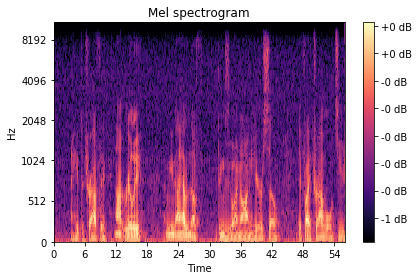

In [23]:
# Show the spectrogram

librosa.display.specshow(sample,
                         y_axis='mel',
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [25]:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)

In [27]:
# dataset_path = 'data/audio_augmented/time_window_10_stride_10_max_10/'
dataset_path = path
filenames = os.listdir(dataset_path)

if ".DS_Store" in filenames:
    filenames.remove(".DS_Store")

sort_nicely(filenames)
Xdb = []    
    
for filename in filenames:
    X, sr = librosa.load(dataset_path + filename)
    X = abs(soundwave_to_np_spectrogram(X))
    X = X[0:95,:]
    Xdb.append(X)

In [34]:
spec_path = "data/spectrogram/audio_augmented/time_window_" + str(time_window) + "_stride_" + str(stride) + "_max_" + str(n_samples_max) + "/"

if not os.path.exists(spec_path):
    os.makedirs(spec_path)

np.asarray(Xdb).dump(open(spec_path +"Xdb.npy", "wb"))
np.asarray(level_array_extended).dump(open(spec_path + 'Y.npy', 'wb'))

In [38]:
number_of_files = int(len(Xdb)/500)
for i in range(number_of_files):
    start = i * 500
    end = start + 500 if start + 500 < len(Xdb) else len(Xdb)
    np.asarray(Xdb[start:end]).dump(open('data/spectrogram/audio_augmented/time_window_10_stride_10_max_10/Xdb_' + str(i) + '.npy', 'wb'))
    np.asarray(level_array_extended[start:end]).dump(open('data/spectrogram/audio_augmented/time_window_10_stride_10_max_10/Y_' + str(i) + '.npy', 'wb'))

In [37]:
'''Xdb = np.load(open('data/spectrogram/audio_augmented/time_window_10_stride_10_max_10/Xdb.npy', 'rb'))'''

"Xdb = np.load(open('data/spectrogram/audio_augmented/time_window_10_stride_10_max_10/Xdb.npy', 'rb'))"

In [35]:
# Size of the spectrogram. Every sample has the same length so only 1 size is calculated.

alto, ancho = Xdb[0].shape
print(alto, ancho)

95 2412


In [36]:
level_array_extended_new = np.asarray(level_array_extended)

In [52]:
#print(np.asarray(Xdb).shape)
print(level_array_extended_new.shape)
len(Xdb)

(1869,)


1869

In [38]:
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

In [63]:
np.unique(level_array_extended_new, return_counts=True)

(array([0, 1, 2, 3, 4]), array([255, 697, 461, 240, 216], dtype=int64))

In [67]:
def distribute_levels(Xdb, level_array):
    Xdb_shuffled, level_array_shuffled = shuffle(Xdb, level_array, random_state=0)
    
    levels, counts = np.unique(level_array, return_counts=True)
    n_levels = len(levels)
    
    
    X = [None] * n_levels
    Y = [None] * n_levels
       
    for i in levels:
        X[i] = np.compress(level_array_shuffled == i, Xdb_shuffled, axis = 0)
        Y[i] = [i] * counts[i]
    
    X = np.array(X)
    Y = np.array(Y)

    return X, Y, levels, counts

In [68]:
X, Y, levels, counts = distribute_levels(Xdb, level_array_extended_new)

In [173]:
def distribute_sets(X, Y, levels, counts, split = [70,14,16]): 
    
    n_levels = len(levels)
        
    X_dict = dict()
    Y_dict = dict()
    
    last = np.zeros(n_levels)
    prev = np.zeros(n_levels)
   
    for p in split:
        X_dict['d'+str(p)] = []
        Y_dict['d'+str(p)] = []
        for i in levels:
            last[i] = min(counts[i], prev[i] + round(counts[i] * p /100.))
       
        X_dict['d'+str(p)] = np.concatenate([X[i][int(prev[i]):int(last[i])] for i in levels], axis = 0)
        Y_dict['d'+str(p)] = np.concatenate([Y[i][int(prev[i]):int(last[i])] for i in levels], axis = 0)
        
        prev = last.copy()
        
        
    return (X_dict['d70'], Y_dict['d70'], X_dict['d14'], Y_dict['d14'], X_dict['d16'], Y_dict['d16'])

In [174]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = distribute_sets(X, Y, levels, counts)

In [176]:
X_test.shape

(298, 95, 2412)

In [177]:
def reshape_to_cnn(X):
    X_reshape = np.asarray(X.reshape(X.shape[0], X.shape[1], X.shape[2], 1))
    return X_reshape

In [278]:
X_train_cnn = reshape_to_cnn(X_train)
X_dev_cnn = reshape_to_cnn(X_dev)
X_test_cnn = reshape_to_cnn(X_test)

Y_train_oh = keras.utils.to_categorical(Y_train)
Y_dev_oh = keras.utils.to_categorical(Y_dev)
Y_test_oh = keras.utils.to_categorical(Y_test)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [256]:
X_train.shape

(1308, 95, 2412)

In [291]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV layer 
    X = Dropout(rate = 0.2)(X_input) 
    X = Conv1D(filters = 100, kernel_size = 2, strides=1)(X)                              # CONV1D
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer
    X = GRU(units = 100, return_sequences = True)(X)                                # GRU (use 128 units and return the sequences)
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer
    X = GRU(units = 100, return_sequences = False)(X)                                  # GRU (use 128 units and return the sequences)
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = Dense(5, activation = "softmax")(X) # sigmoid

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [292]:
model = model(input_shape = X_train[0].shape)

In [293]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 95, 2412)          0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 95, 2412)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 94, 100)           482500    
_________________________________________________________________
batch_normalization_61 (Batc (None, 94, 100)           400       
_________________________________________________________________
activation_14 (Activation)   (None, 94, 100)           0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 94, 100)           0         
_________________________________________________________________
gru_22 (GRU)                 (None, 94, 100)           60300     
__________

In [294]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [296]:
model_2gru_hist = model.fit(X_train, Y_train_oh, validation_data=(X_dev, Y_dev_oh), epochs = 30, batch_size = 64, shuffle = True, callbacks=[early_stopping])

Train on 1308 samples, validate on 263 samples
Epoch 1/30
1308/1308 [==============================] - 10s 8ms/step - loss: 1.5570 - acc: 0.3456 - val_loss: 1.6493 - val_acc: 0.3726
Epoch 2/30
1308/1308 [==============================] - 10s 8ms/step - loss: 1.5244 - acc: 0.3448 - val_loss: 1.6616 - val_acc: 0.1445
Epoch 3/30
1308/1308 [==============================] - 11s 8ms/step - loss: 1.5023 - acc: 0.3578 - val_loss: 1.6475 - val_acc: 0.1597
Epoch 4/30
1308/1308 [==============================] - 11s 9ms/step - loss: 1.4918 - acc: 0.3739 - val_loss: 1.5311 - val_acc: 0.3878
Epoch 5/30
1308/1308 [==============================] - 11s 9ms/step - loss: 1.4718 - acc: 0.3807 - val_loss: 1.5500 - val_acc: 0.3384
Epoch 6/30
1308/1308 [==============================] - 11s 9ms/step - loss: 1.4861 - acc: 0.3769 - val_loss: 2.3050 - val_acc: 0.1293
Epoch 7/30
1308/1308 [==============================] - 12s 9ms/step - loss: 1.4941 - acc: 0.3899 - val_loss: 1.9748 - val_acc: 0.1217
Epoch 8/

In [290]:
with open('models/model_2gru_hist.json', 'w') as f:
    json.dump(model_2gru_hist.history, f)
model.save('models/model_2gru.h5')

In [311]:
score = model.evaluate(X_test, Y_test_oh, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7908938635115657
Test accuracy: 0.1476510067114094


In [325]:
Y_predict = model.predict(X_test) 
confusionmatrix = confusion_matrix(Y_test_oh.argmax(axis=1), Y_predict.argmax(axis=1))
print(confusionmatrix)

[[  0   0   0  41   0]
 [  0   6   0 105   0]
 [  0   0   0  73   0]
 [  0   0   0  38   0]
 [  0   0   0  35   0]]


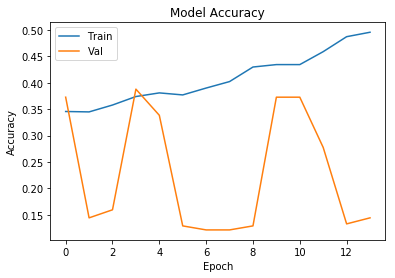

In [298]:
plot_acc(model_2gru_hist)

In [302]:
def model_cnn(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV2D layer 
    X = Conv2D(filters = 50, kernel_size = (5,5), strides=(1, 4), padding='same', data_format="channels_last", activation='relu')(X_input)      # CONV2D
    X = MaxPooling2D(pool_size=(2, 4))(X)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Dropout(rate = 0.4)(X)                                 # dropout 

    # Step 2: CONV2D Layer
    X = Conv2D(filters = 100, kernel_size = (5,5), strides=(1, 2), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
    X = MaxPooling2D(pool_size=(2, 3))(X)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Dropout(rate = 0.4)(X)                                 # dropout 
    
#     # Step 3: CONV2D Layer
#     X = Conv2D(filters = 128, kernel_size = (3,3), strides=(1, 1), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
#     X = MaxPooling2D(pool_size=(2, 3))(X)
#     X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
#     X = Dropout(rate = 0.4)(X)   # dropout 
    
#     # Step 4: CONV2D Layer
#     X = Conv2D(filters = 250, kernel_size = (3,3), strides=(1, 1), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
#     X = MaxPooling2D(pool_size=(2, 2))(X)
#     X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
#     X = Dropout(rate = 0.2)(X)   # dropout 
    
    # Step 4: Flatten and dense layer
    X = Flatten()(X)
    X = Dense(5, activation = "relu")(X)
    X = Dense(5, activation = "softmax")(X)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [303]:
model_cnn = model_cnn(input_shape = X_train_cnn[0].shape)

In [304]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 95, 2412, 1)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 95, 603, 50)       1300      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 47, 150, 50)       0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 47, 150, 50)       200       
_________________________________________________________________
dropout_74 (Dropout)         (None, 47, 150, 50)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 47, 75, 100)       125100    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 23, 25, 100)       0         
__________

In [305]:
model_cnn.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [306]:
# log best model
checkpoint_best     = ModelCheckpoint('model_cnn_best',   monitor='loss', verbose=0, save_best_only=True, mode='auto')

# log improved model
checkpoint_epochs   = ModelCheckpoint('model_cnn_epochs', monitor='loss', verbose=0, save_best_only=True, mode='auto')


In [307]:
model_cnn_hist = model_cnn.fit(X_train_cnn, Y_train_oh, validation_data=(X_dev_cnn, Y_dev_oh), epochs = 10, batch_size = 64, shuffle = True, callbacks=[early_stopping, checkpoint_best, checkpoint_epochs])

Train on 1308 samples, validate on 263 samples
Epoch 1/10
1308/1308 [==============================] - 157s 120ms/step - loss: 1.7430 - acc: 0.2645 - val_loss: 1.6780 - val_acc: 0.2510
Epoch 2/10
1308/1308 [==============================] - 164s 126ms/step - loss: 1.6424 - acc: 0.3624 - val_loss: 4.1314 - val_acc: 0.3498
Epoch 3/10
1308/1308 [==============================] - 162s 124ms/step - loss: 1.6227 - acc: 0.3731 - val_loss: 1.6626 - val_acc: 0.3764
Epoch 4/10
1308/1308 [==============================] - 165s 126ms/step - loss: 1.6255 - acc: 0.3723 - val_loss: 1.6387 - val_acc: 0.3688
Epoch 5/10
1308/1308 [==============================] - 165s 126ms/step - loss: 1.6265 - acc: 0.3723 - val_loss: 1.6269 - val_acc: 0.3688
Epoch 6/10
1308/1308 [==============================] - 160s 122ms/step - loss: 1.6076 - acc: 0.3723 - val_loss: 1.6268 - val_acc: 0.3688
Epoch 7/10
1308/1308 [==============================] - 167s 127ms/step - loss: 1.6008 - acc: 0.3723 - val_loss: 1.6212 - val

In [313]:
score = model_cnn.evaluate(X_test_cnn, Y_test_oh, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6002252173903804
Test accuracy: 0.3724832214765101


In [327]:
Y_predict = model_cnn.predict(X_test_cnn) 
confusionmatrix = confusion_matrix(Y_test_oh.argmax(axis=1), Y_predict.argmax(axis=1))
print(confusionmatrix)

[[  0  40   0   0   1]
 [  0 111   0   0   0]
 [  0  73   0   0   0]
 [  0  38   0   0   0]
 [  0  35   0   0   0]]


In [330]:
Y_predict.shape

(298, 5)

In [297]:
with open('models/model_cnn_hist.json', 'w') as f:
    json.dump(model_cnn_hist.history, f)
model_cnn.save('models/model_cnn.h5')

In [231]:
def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1", name2="Red 2", title="Graph title"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_multiple_metrics(history_array, names, colors, title="Graph title", metric='acc'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

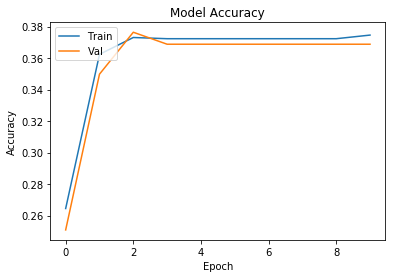

In [309]:
plot_acc(model_cnn_hist)